# **Imports:**

----

In [2]:
from requests import get
from bs4 import BeautifulSoup
import os
import requests
import pandas as pd
import unicodedata
import re
import json

import matplotlib.pyplot as plt

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import prepare

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

-----

# **Acquire:**

In [3]:
#utilizing json file created from acquire.py, using pandas read json to create a dataframe
df = pd.read_json('data2.json')

In [5]:
#initial is 225 records x 3 fields, all are objects.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             225 non-null    object
 1   language         225 non-null    object
 2   readme_contents  225 non-null    object
dtypes: object(3)
memory usage: 5.4+ KB


------

------

# **Prepare:**

In [6]:
#utilizing prepare function which will retrun a df containing original columns and columns which have been normalized, lemmatized, tokenized and had stopwords removed or added.
df = prepare.prep_repo_data(df)

In [7]:
#looking at the initial and new columns.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 198
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   repo_name                174 non-null    object
 1   language                 174 non-null    object
 2   readme_contents          174 non-null    object
 3   repo_name_cleaned        174 non-null    object
 4   language_cleaned         174 non-null    object
 5   readme_contents_cleaned  174 non-null    object
dtypes: object(6)
memory usage: 9.5+ KB


In [8]:
#shape after prepare is 174 records by 6 fields
df.shape

(174, 6)

In [9]:
df.head(10)

,repo_name,language,readme_contents,repo_name_cleaned,language_cleaned,readme_contents_cleaned
0,IrisShaders/Iris,Java,![Iris: An open-source shaders mod compatible ...,irisshadersiris,java,iris opensource shaders mod compatible optifin...
1,returntocorp/semgrep,Java,"</br>\n<p align=""center"">\n <a href=""https:...",returntocorpsemgrep,java,br p aligncenter hrefhttpssemgrepdevimg srchtt...
2,CaffeineMC/sodium-fabric,Java,"<img src=""src/main/resources/assets/sodium/ico...",caffeinemcsodiumfabric,java,img srcsrcmainresourcesassetssodiumiconpng wid...
3,keycloak/keycloak,Java,# Keycloak\n\nKeycloak is an Open Source Ident...,keycloakkeycloak,java,keycloak keycloak open source identity access ...
4,NationalSecurityAgency/ghidra,Java,"<img src=""Ghidra/Features/Base/src/main/resour...",nationalsecurityagencyghidra,java,img srcghidrafeaturesbasesrcmainresourcesimage...
5,alibaba/Sentinel,Java,"<img src=""https://user-images.githubuserconten...",alibabasentinel,java,img srchttpsuserimagesgithubusercontentcom9434...
6,square/okhttp,Java,OkHttp\n======\n\nSee the [project website][ok...,squareokhttp,java,okhttp see project websiteokhttp documentation...
7,alibaba/nacos,Java,"\n<img src=""doc/Nacos_Logo.png"" width=""50%"" sy...",alibabanacos,java,img srcdocnacoslogopng width50 syt height50 na...
8,opensearch-project/OpenSearch,Java,"<img src=""https://opensearch.org/assets/brand/...",opensearchprojectopensearch,java,img srchttpsopensearchorgassetsbrandsvglogoope...
9,sqshq/piggymetrics,Java,[![Build Status](https://travis-ci.org/sqshq/P...,sqshqpiggymetrics,java,build statushttpstravisciorgsqshqpiggymetricss...


In [10]:
#changing the column readme contents to only be a total character size of 18 or less
df['readme_contents_cleaned'] = df['readme_contents_cleaned'].str.findall('\w{1,18}').str.join(' ')


In [11]:
def lang_split(df):
    '''
    This function take in the readme data acquired
    performs a split and stratifies language_cleaned column.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=245, 
                                        stratify=df.language_cleaned)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=245, 
                                   stratify=train_validate.language_cleaned)
    return train, validate, test

In [12]:
df.language.value_counts()

JavaScript    47
Python        47
Java          42
R             38
Name: language, dtype: int64

In [13]:
#splitting the data into a train, validate and test set
train, validate, test = lang_split(df)

-----

# **Exploratory**:

In [15]:
# splitting the readmes into strings
java_read = ' '.join(train[train.language_cleaned == 'java'].readme_contents_cleaned)
python_read = ' '.join(train[train.language_cleaned == 'python'].readme_contents_cleaned)
r_read = ' '.join(train[train.language_cleaned == 'r'].readme_contents_cleaned)
javascript_read = ' '.join(train[train.language_cleaned == 'javascript'].readme_contents_cleaned)
all_content = ' '.join(train.readme_contents_cleaned)

In [16]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(train, "language_cleaned")

,n,percent
python,26,0.268041
javascript,26,0.268041
java,24,0.247423
r,21,0.216495


In [17]:
#creating word frequencies
java_freq = pd.Series(java_read.split()).value_counts()
python_freq = pd.Series(python_read.split()).value_counts()
r_freq= pd.Series(r_read.split()).value_counts()
javascript_freq= pd.Series(javascript_read.split()).value_counts()
all_freq = pd.Series(all_content.split()).value_counts()

In [18]:
#combining series into one which is shows word count for each word for each language.
word_counts = (pd.concat([java_freq, python_freq, r_freq, javascript_freq, all_freq], axis=1, sort=True)
                .fillna(0)
                .apply(lambda s: s.astype(int)))



In [19]:
#splitting the string into a list of words.
java_words = re.sub(r'[^\w\s]', '', java_read).split()
r_words = re.sub(r'[^\w\s]', '', r_read).split()
python_words = re.sub(r'[^\w\s]', '', python_read).split()
javascript_words = re.sub(r'[^\w\s]', '', javascript_read).split()
all_content_words = re.sub(r'[^\w\s]', '', all_content).split()


In [20]:
#naming the columns
word_counts.columns = ['java', 'python', 'r', 'javascript', 'all_content']

In [21]:
word_counts.sort_values('python', ascending = False).head(50)

,java,python,r,javascript,all_content
yes,0,1014,0,9,1023
unknown,0,626,0,3,629
data,25,430,99,346,900
api,33,423,1,45,502
learning,1,388,11,3,403
apikey,0,343,0,2,345
machine,5,334,7,17,363
video,0,291,0,12,303
library,17,290,6,27,340
python,5,270,7,2,284


In [22]:
#type 20 words for python
python_top_20 = word_counts.python.sort_values(ascending = False).head(40)

In [23]:
#java top 20 words
java_top_20 = word_counts.java.sort_values(ascending = False).head(40)

In [24]:
#javascript top 20 words
javascript_top_20 = word_counts.javascript.sort_values(ascending = False).head(40)

In [25]:
#r top 20 words
r_top_20 = word_counts.r.sort_values(ascending = False).head(40)

In [26]:
# function to graph ngrams
def ngram_charts(content, n):
    content_word_str = ' '.join(content)
    ngrams = (pd.Series(nltk.ngrams(content_word_str, n)).value_counts())
    ngrams.plot.barh()



In [27]:
#function to create word clouds
def word_cloud(word_string, name):
    from wordcloud import WordCloud
    img = WordCloud(background_color='white', width=800, height=600).generate(word_string)
    print('-------------------')
    print(f'{name}')
    print('-------------------')
    plt.imshow(img)
    plt.axis('off')

In [28]:
def df_to_wordcloud(df, language = None):
    if language: 
        df = df[df.language_cleaned == language]
    else:
        language = 'all_language'
    to_list = ''
    for readme in df.readme_contents_cleaned:
        to_list += readme
    word_cloud(to_list,language)

# Visual Exploration:

## Bigrams

In [31]:
java_bigrams = (pd.Series(nltk.ngrams(java_words, 2))
                      .value_counts()
                      .head(10))

java_bigrams.tail()

(open, source)                              10
(spring, boot)                              10
(make, sure)                                 9
(srchttpscloudgithu, busercontentcomass)     8
(get, 9)                                     7
dtype: int64

<AxesSubplot:>

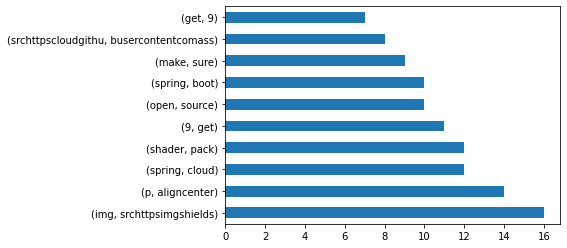

In [32]:
java_bigrams.plot.barh()

In [33]:
python_bigrams = (pd.Series(nltk.ngrams(python_words, 2))
                      .value_counts()
                      .head(10))

python_bigrams.head(40)

(yes, unknown)               536
(apikey, yes)                319
(machine, learning)          260
(yes, yes)                   211
(oauth, yes)                 106
(neural, network)            103
(natural, language)           69
(generalpurpose, machine)     60
(deep, learning)              54
(data, analysis)              50
dtype: int64

<AxesSubplot:>

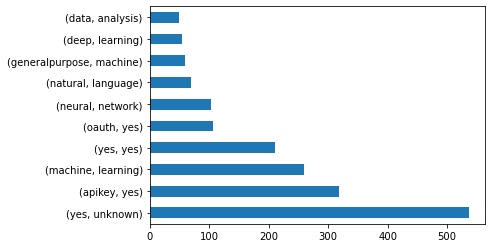

In [34]:
python_bigrams.plot.barh()

In [35]:
javascript_bigrams = (pd.Series(nltk.ngrams(javascript_words, 2))
                      .value_counts()
                      .head(10))

javascript_bigrams.head(40)

(freewarefreeware, icon)                    364
(targetblankimg, srchttpsopencollec)        335
(ul, li)                                    294
(opensource, softwareoss)                   235
(softwareoss, iconhttpsgithubcom)           205
(javascript, bad)                           111
(hrefhttpsopencolle, ctivecomwebpackbac)    102
(hrefhttpsopencolle, ctivecomwebpackspo)    102
(srchttpsopencollec, tivecomwebpackspon)    102
(srchttpsopencollec, tivecomwebpackback)    102
dtype: int64

<AxesSubplot:>

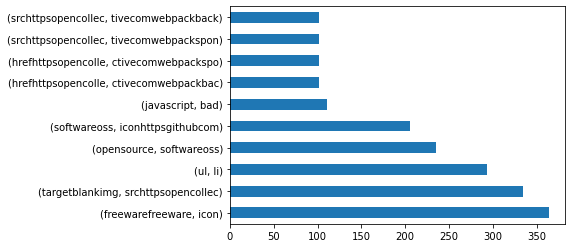

In [36]:
javascript_bigrams.plot.barh()

In [37]:
r_bigrams = (pd.Series(nltk.ngrams(r_words, 2))
                      .value_counts()
                      .head(10))

r_bigrams.head(40)

(time, series)                              22
(data, mtcars)                              19
(hp, disp)                                  15
(disp, data)                                15
(supernovalmmpg, hp)                        14
(deprecated, use)                           11
(r, evalfalse)                              11
(use, package)                              11
(mtcars, type)                              10
(badgehttpsimgshiel, dsiostaticv1stylef)    10
dtype: int64

<AxesSubplot:>

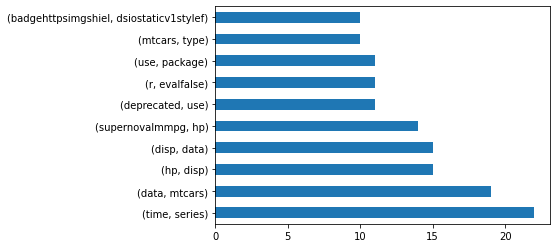

In [38]:
r_bigrams.plot.barh()

In [39]:
r_words_string = ' '.join(r_words)
python_words_string = ' '.join(python_words)
java_words_string = ' '.join(java_words)
javascript_words_string = ' '.join(javascript_words)

str

------

### **Looking into language specific words.**

-----

### Python Only Words

In [40]:
commonlist_pr = []
for i in python_words:
    for j in r_words:
        if i == j:
            commonlist_pr.append(i)
            
commonlist_pr = pd.DataFrame(commonlist_pr)
commonlist_pr = commonlist_pr[0].drop_duplicates().values
list1 = commonlist_pr.tolist()

In [41]:
commonlist_pj = []
for i in python_words:
    for j in java_words:
        if i == j:
            commonlist_pj.append(i)
            
commonlist_pj = pd.DataFrame(commonlist_pj)
commonlist_pj = commonlist_pj[0].drop_duplicates().values
list2 = commonlist_pj.tolist()

In [42]:
commonlist_pjs = []
for i in python_words:
    for j in javascript_words:
        if i == j:
            commonlist_pjs.append(i)
            
commonlist_pjs = pd.DataFrame(commonlist_pjs)
commonlist_pjs = commonlist_pjs[0].drop_duplicates().values
list3 = commonlist_pjs.tolist()


In [43]:
#create a df which will be python words not in list 1 list 2 list3
python_only_words = []
for i in python_words:
    if i not in list1 and i not in list2 and i not in list3:
        python_only_words.append(i)
        
        

In [44]:
python_only = ' '.join(python_only_words)

-------------------
python
-------------------


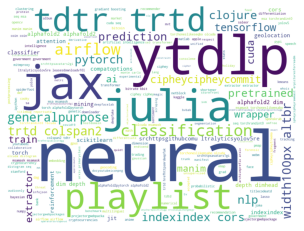

In [45]:
word_cloud(python_only, 'python')

------

### Java Only Words

In [46]:
commonlist_jr = []
for i in java_words:
    for j in r_words:
        if i == j:
            commonlist_jr.append(i)
            
commonlist_jr = pd.DataFrame(commonlist_jr)
commonlist_jr = commonlist_jr[0].drop_duplicates().values
list1 = commonlist_jr.tolist()

In [47]:
commonlist_jjs = []
for i in java_words:
    for j in javascript_words:
        if i == j:
            commonlist_jjs.append(i)
            
commonlist_jjs = pd.DataFrame(commonlist_jjs)
commonlist_jjs = commonlist_jjs[0].drop_duplicates().values
list2 = commonlist_jjs.tolist()

In [48]:
commonlist_jp = []
for i in java_words:
    for j in python_words:
        if i == j:
            commonlist_jp.append(i)
            
commonlist_jp = pd.DataFrame(commonlist_jp)
commonlist_jp = commonlist_jp[0].drop_duplicates().values
list3 = commonlist_jp.tolist()

In [49]:
#create a df which will be python words not in list 1 list 2 list3
java_only_words = []
for i in java_words:
    if i not in list1 and i not in list2 and i not in list3:
        java_only_words.append(i)
        
        

In [64]:
java_only = ' '.join(java_only_words)

In [65]:
j_only = java_only.split()

In [66]:
j_only_bigrams = (pd.Series(nltk.ngrams(j_only, 3))
                      .value_counts()
                      .head(20))

<AxesSubplot:>

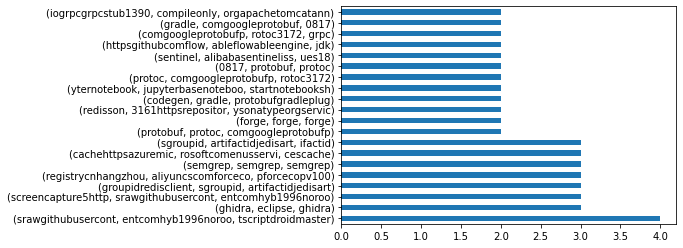

In [67]:
j_only_bigrams.plot.barh()

-------------------
java
-------------------


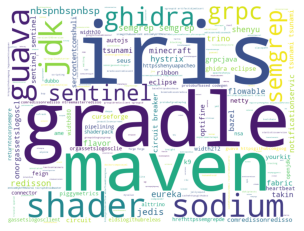

In [68]:
word_cloud(java_only, 'java')

-------

### R Words Only

In [69]:
commonlist_rj = []
for i in r_words:
    for j in java_words:
        if i == j:
            commonlist_rj.append(i)
            
commonlist_rj = pd.DataFrame(commonlist_rj)
commonlist_rj = commonlist_rj[0].drop_duplicates().values
list1 = commonlist_rj.tolist()

In [70]:
commonlist_rjs = []
for i in r_words:
    for j in javascript_words:
        if i == j:
            commonlist_rjs.append(i)
            
commonlist_rjs = pd.DataFrame(commonlist_rjs)
commonlist_rjs = commonlist_rjs[0].drop_duplicates().values
list2 = commonlist_rjs.tolist()

In [71]:
commonlist_rp = []
for i in r_words:
    for j in python_words:
        if i == j:
            commonlist_rp.append(i)
            
commonlist_rp = pd.DataFrame(commonlist_rp)
commonlist_rp = commonlist_rp[0].drop_duplicates().values
list3 = commonlist_rp.tolist()

In [72]:
#create a df which will be python words not in list 1 list 2 list3
r_only_words = []
for i in r_words:
    if i not in list1 and i not in list2 and i not in list3:
        r_only_words.append(i)
        
        

In [73]:
r_only = ' '.join(r_only_words)

In [74]:
r_only_words = r_only.split()

In [75]:
r_only_bigrams = (pd.Series(nltk.ngrams(r_only_words, 3))
                      .value_counts()
                      .head(20))

<AxesSubplot:>

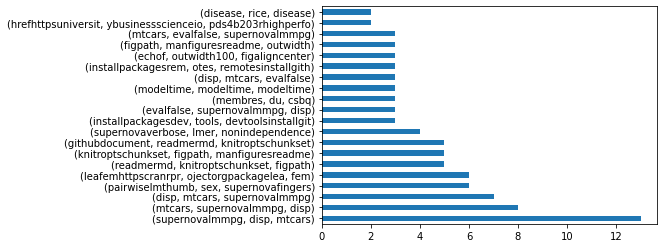

In [76]:
r_only_bigrams.plot.barh()

In [77]:
r_only = ' '.join(r_only_words)

-------------------
r
-------------------


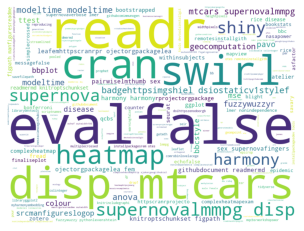

In [78]:
word_cloud(r_only, 'r')

------

In [79]:
commonlist_jsr = []
for i in javascript_words:
    for j in r_words:
        if i == j:
            commonlist_jsr.append(i)
            
commonlist_jsr = pd.DataFrame(commonlist_jsr)
commonlist_jsr = commonlist_jsr[0].drop_duplicates().values
list1 = commonlist_jsr.tolist()

In [80]:
commonlist_jsj = []
for i in javascript_words:
    for j in java_words:
        if i == j:
            commonlist_jsj.append(i)
            
commonlist_jsj = pd.DataFrame(commonlist_jsj)
commonlist_jsj
commonlist_jsj = commonlist_jsj[0].drop_duplicates().values
list2 = commonlist_jsj.tolist()

In [81]:
commonlist_jsp = []
for i in javascript_words:
    for j in python_words:
        if i == j:
            commonlist_jsp.append(i)
            
commonlist_jsp = pd.DataFrame(commonlist_jsp)
commonlist_jsp = commonlist_jsp[0].drop_duplicates().values
list3 = commonlist_jsp.tolist()

In [91]:
#create a df which will be python words not in list 1 list 2 list3
javascript_only_words = []
for i in javascript_words:
    if i not in list1 and list2 and list3:
        javascript_only_words.append(i)
        
        

In [92]:
#note maven
pd.DataFrame(javascript_only_words).value_counts(normalize= True).head(50)

ul                    0.025492
icon                  0.010341
freewarefreeware      0.009455
li                    0.008593
srchttpsopencollec    0.008497
hrefhttpsopencolle    0.008402
const                 0.008115
worldwide             0.007205
softwareoss           0.006295
iconhttpsgithubcom    0.006008
opensource            0.005649
javascript            0.005218
bad                   0.004955
h4                    0.004835
aws                   0.003926
usa                   0.003758
service               0.003519
h3                    0.003303
event                 0.002801
foo                   0.002777
span                  0.002729
public                0.002537
ec2                   0.002465
tivecomwebpackspon    0.002442
ctivecomwebpackbac    0.002442
tivecomwebpackback    0.002442
ctivecomwebpackspo    0.002442
eactivefalse          0.002394
reactivefalsea        0.002394
vpc                   0.002322
storage               0.002322
td                    0.002274
eslint  

In [93]:
javascript_only = ' '.join(javascript_only_words)

In [94]:
js_only = javascript_only.split()

In [95]:
js_only_bigrams = (pd.Series(nltk.ngrams(js_only, 3))
                      .value_counts()
                      .head(10))

<AxesSubplot:>

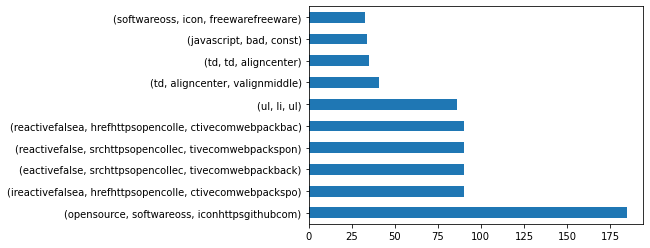

In [96]:
js_only_bigrams.plot.barh()

-------------------
javascript
-------------------


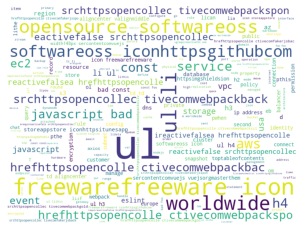

In [97]:
word_cloud(javascript_only, 'javascript')

In [98]:
common = []
for i in all_content_words:
    if i in java_words:
        if i in javascript_words:
            if i in r_words:
                if i in python_words:
                    common.append(i)

In [99]:
common_top20 = pd.Series(common).value_counts().head(5).index.tolist()
common_top20

['data', 'use', 'api', 'using', '1']

---

-------

# Modeling:

### TF-IDF

In [110]:
tfidf = TfidfVectorizer(stop_words = ['data','use'])
X_data_tfidf = tfidfs = tfidf.fit_transform(df.readme_contents_cleaned)
y_data_tfidf = df.language_cleaned

pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())

,00,0000,000000000000000000,000000082ae3910733,00004566,0000512,0000708,0001,000149325locationl,00025,...,zzuy90jx4m3o5ilxvf,zzw50ihbyzxnlcnzli,zzwm,zzxjgdnjralu9ljbuz,zzxk5o3mfmcdoljff6,zzxm52sbkygbdncxcy,zzxocesxnv6bm5u4vg,zzxq8clswxs5vzmzzz,zzxqgbxv0zxggbmftz,zzxrfdw5kzxjmbg93x
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
cv = CountVectorizer()
#fitting on bag of words but can do it on tfidf scores 
X_data_bg = cv.fit_transform(df.readme_contents_cleaned)
y_data_bg = df.language_cleaned

In [112]:
def xy_split(X, y):
    '''
    This function take in the readme data acquired
    performs a split and stratifies language_cleaned column.
    Returns train, validate, and test dfs.
    '''
    X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=.2, 
                                                                          random_state=254, 
                                                                          stratify = y)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, test_size=.3,random_state=254,stratify= y_train_validate)
    return X_train, X_validate, y_train, y_validate, X_test, y_test

In [113]:
X_train, X_validate, y_train, y_validate, X_test, y_test = xy_split(X_data_tfidf,y_data_tfidf)

## Creating the baseline

In [114]:
y_train.value_counts()

python        26
javascript    26
java          24
r             21
Name: language_cleaned, dtype: int64

In [115]:
train['baseline'] = 'python'

In [116]:
#create out thing
baseline = DummyClassifier(strategy = 'constant', constant = 'python')
#fit our thing
baseline.fit(X_train, y_train)
# what is the accuracy value 
print('Baseline accuracy: %.4f' % baseline.score(X_train, y_train))

Baseline accuracy: 0.2680


## Decision Tree Classifier

In [117]:
tree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 7,)
tree.fit(X_train, y_train)

train = pd.DataFrame(dict(actual =y_train))
train['predicted'] = tree.predict(X_train)

print(f'train score :{tree.score(X_train, y_train):.2%}')
print(f'validate score :{tree.score(X_validate, y_validate):.2%}')

train score :74.23%
validate score :66.67%


## KNN 

In [119]:
knn = KNeighborsClassifier(n_neighbors=(9))
knn.fit(X_train, y_train)

train = pd.DataFrame(dict(actual =y_train))
train['predicted'] = tree.predict(X_train)

print(f'train score :{knn.score(X_train, y_train):.2%}')
print(f'validate score :{knn.score(X_validate, y_validate):.2%}')

train score :78.35%
validate score :78.57%


# Evaluate on test

In [120]:
#create prediction column
test['predicted'] = knn.predict(X_test)
#accuracy score
print(f'Test score: {knn.score(X_test, y_test):.2%}')

Test score: 88.57%
